In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
import os
import shutil
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [8]:
dataset_path = "C:/Users/attis/OneDrive/Desktop/Final-Year-Project/dataset_for_blood_group/"


In [9]:
BATCH_SIZE = 32

In [10]:
# Step 1: Load dataset
dataset = image_dataset_from_directory(
    dataset_path,
    labels="inferred",
    label_mode="int",
    image_size=(64, 64),  #Resize images to a standard size
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 6000 files belonging to 8 classes.


In [11]:
 # Step 2:Check class distribution
class_names = dataset.class_names
class_counts = Counter()
for _, labels in dataset.unbatch():
  class_counts[int(labels.numpy())] += 1

print("Class Distribution")
for i, count in class_counts.items():
  print(f"{class_names[i]}: {count}")

Class Distribution
AB-: 761
O+: 852
A+: 565
AB+: 708
A-: 1009
B+: 652
O-: 712
B-: 741


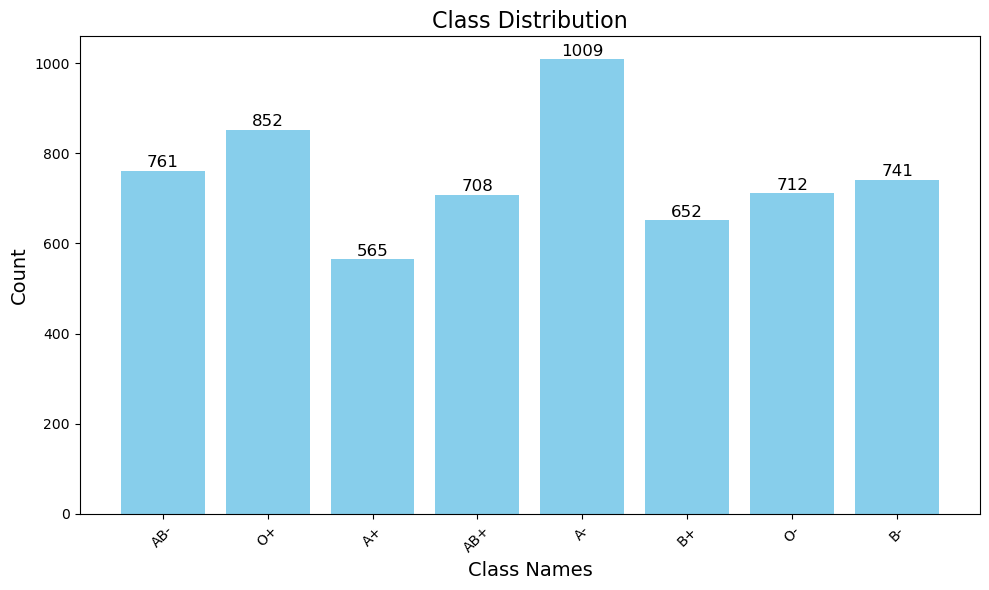

In [12]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_class_distribution(class_names, class_counts):
    """
    Visualize the class distribution as a bar chart with counts above each bar.

    Args:
        class_names (list): List of class labels.
        class_counts (Counter or dict): A mapping of class indices to their counts.
    """
    # Convert class indices to names
    class_labels = [class_names[i] for i in class_counts.keys()]
    class_values = list(class_counts.values())

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(class_labels, class_values, color='skyblue')

    # Add counts above each bar
    for bar, value in zip(bars, class_values):
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # Center of the bar
            bar.get_height() + 1,              # Slightly above the bar
            str(value),                        # The count value
            ha='center', va='bottom', fontsize=12  # Center-aligned
        )

    # Customize the plot
    plt.xlabel('Class Names', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.title('Class Distribution', fontsize=16)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


plot_class_distribution(class_names, class_counts)

In [13]:
max_count = max(class_counts.values())

In [14]:
# Function to oversample a class
def oversample_class(class_id, count, max_count):
  # Ensure the dataset is unbatched for filtering
  unbatched_dataset = dataset.unbatch()

  #Filter the dataset for the specific class
  class_dataset = unbatched_dataset.filter(lambda img, lbl: tf.equal(lbl, class_id))

  # calculate the number of repetitions needed
  repeat_factor = max_count // count + (max_count % count > 0)

  # Repeat the dataset to match the desired count
  return class_dataset.repeat(repeat_factor).take(max_count)

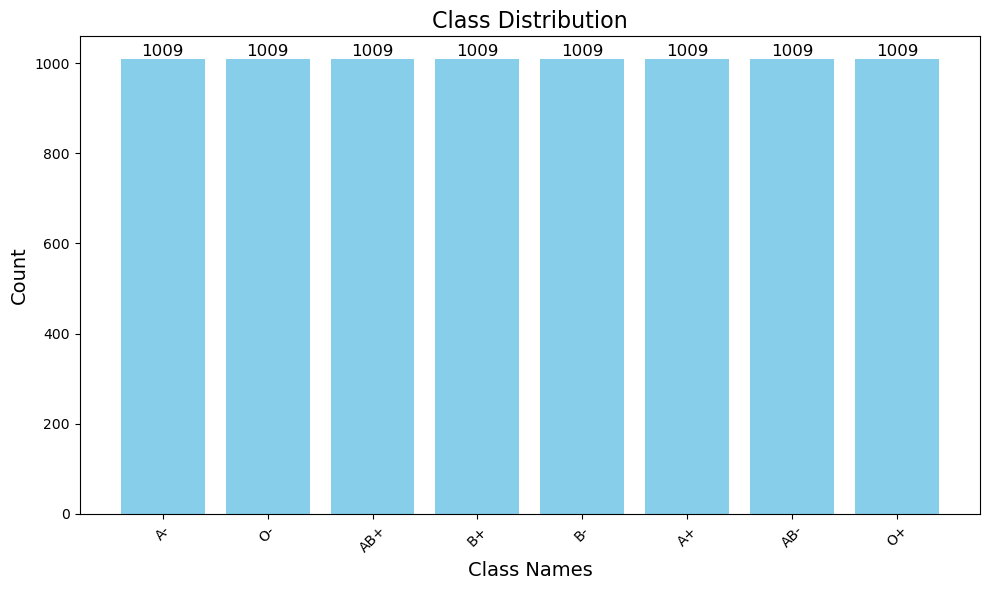

In [15]:
# Step 1: Balance the dataset
balanced_datasets = []
for class_id, count in class_counts.items():
  balanced_datasets.append(oversample_class(class_id, count, max_count))

# Step 2: Combine balanced datasets
balanced_dataset = tf.data.Dataset.sample_from_datasets(balanced_datasets)

# Step 3: check balanced class distribution
balanced_class_counts = Counter([int(lbl.numpy()) for _, lbl in balanced_dataset])
plot_class_distribution(class_names, balanced_class_counts)

# Step 4: Batch the balanced dataset
balanced_dataset = balanced_dataset.batch(BATCH_SIZE,drop_remainder=True)

In [16]:
for sample in balanced_dataset.take(10):
  print(sample[0].shape)

(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)


In [17]:
balanced_dataset_unbatched = balanced_dataset.unbatch()
dataset_size = sum(1 for _ in balanced_dataset_unbatched)
print(f"Total dataset size: {dataset_size}")

Total dataset size: 8064


In [18]:
# Define dataset split ratios
train_ratio = 0.7  # 70% for training
val_ratio = 0.2    # 20% for validation
test_ratio = 0.1   # 10% for testing

# unbatch the dataset to work at the simple level
balanced_dataset_unbatched = balanced_dataset.unbatch()

# Compute sizes based on dataset size and desired splits
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)

# Split the dataset into training, validation, and test
train_dataset = balanced_dataset_unbatched.take(train_size)
val_test_dataset = balanced_dataset_unbatched.skip(train_size)
val_dataset = val_test_dataset.take(val_size)
test_dataset = val_test_dataset.skip(val_size)

# Rebatch the datasets after splitting
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

# Check the number of batches in each dataset
train_batch_count = sum(1 for _ in train_dataset)
val_batch_count = sum(1 for _ in val_dataset)
test_batch_count = sum(1 for _ in test_dataset)

print(f"Training dataset size: {train_batch_count * BATCH_SIZE}")
print(f"Validation dataset size: {val_batch_count * BATCH_SIZE}")
print(f"Testing dataset size: {test_batch_count * BATCH_SIZE}")

Training dataset size: 5632
Validation dataset size: 1600
Testing dataset size: 800


In [19]:
import tensorflow as tf

def create_high_accuracy_model():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(64, 64, 3)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.3),

      tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.4),

      tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.4),

      tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.4),

      tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Dropout(0.5),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(1024, activation='relu'),
      tf.keras.layers.Dropout(0.5),

      tf.keras.layers.Dense(len(class_names), activation='softmax')
  ])

  model.compile(
      optimizer='adam',
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
      )
  return model


# Create the model
high_acc_model = create_high_accuracy_model()

In [20]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define ReduceLROnPlateau callback to reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',           # Monitor validation loss
    factor=0.5,                   # Reduce the learning rate by a factor of 0.5
    patience=3,                   # Wait for 3 epochs without imporvement before reducing LR
    verbose=1,                    # Print a message when the learning rate is reduced
    min_lr=1e-6                   # Minimum learning rate to avoid too small values
)

# Define EarlyStopping callback to stop training when validation loss doesn't improve
early_stop = EarlyStopping(
    monitor='val_loss',           # Monitor validation loss
    patience=5,                   # Stop after 5 epochs without improvement
    verbose=1,                    # Print a message when training is stopped
    restore_best_weights=True     # Restore the model weights from the best epoch
)


In [21]:
# Train the model

history_high_acc = high_acc_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,  # Adjust the number of epochs based on your preference
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/50
176/176 [==============================] - 91s 512ms/step - loss: 10.6367 - accuracy: 0.1440 - val_loss: 2.0719 - val_accuracy: 0.1262 - lr: 0.0010
Epoch 2/50
176/176 [==============================] - 93s 527ms/step - loss: 1.7593 - accuracy: 0.3230 - val_loss: 1.9944 - val_accuracy: 0.2738 - lr: 0.0010
Epoch 3/50
176/176 [==============================] - 94s 530ms/step - loss: 1.4236 - accuracy: 0.4521 - val_loss: 1.6366 - val_accuracy: 0.4931 - lr: 0.0010
Epoch 4/50
176/176 [==============================] - 92s 516ms/step - loss: 1.1205 - accuracy: 0.5820 - val_loss: 1.3896 - val_accuracy: 0.5537 - lr: 0.0010
Epoch 5/50
176/176 [==============================] - 91s 513ms/step - loss: 0.9753 - accuracy: 0.6452 - val_loss: 1.3262 - val_accuracy: 0.5744 - lr: 0.0010
Epoch 6/50
176/176 [==============================] - 91s 515ms/step - loss: 0.8525 - accuracy: 0.6879 - val_loss: 0.9858 - val_accuracy: 0.7812 - lr: 0.0010
Epoch 7/50
176/176 [==============================]

In [22]:
# Evaluate the model on validation data
high_acc_eval = high_acc_model.evaluate(val_dataset)
print(f"High Accuracy Model - Loss: {high_acc_eval[0]}, Accuracy: {high_acc_eval[1]}")

50/50 [==============================] - 25s 140ms/step - loss: 0.3279 - accuracy: 0.9300
High Accuracy Model - Loss: 0.32789289951324463, Accuracy: 0.9300000071525574


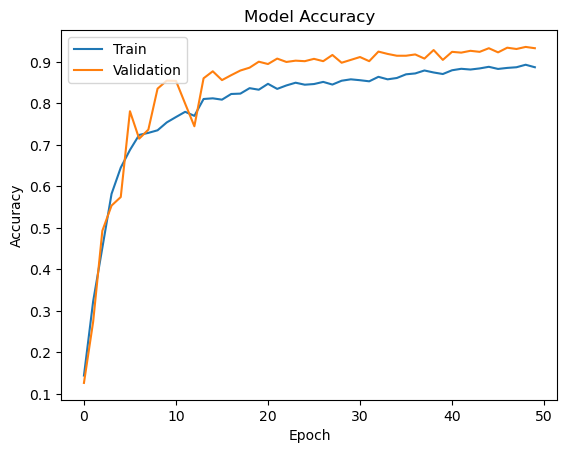

In [23]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Call the function to display the acccuracy graph
plot_accuracy(history_high_acc)

1/1 [==============================] - 0s 60ms/step
Classification Report:
              precision    recall  f1-score   support

          A+       0.90      0.99      0.95        96
          A-       0.84      0.93      0.89        58
         AB+       0.96      0.98      0.97       104
         AB-       1.00      0.97      0.98       148
          B+       0.94      0.95      0.94        80
          B-       0.97      0.95      0.96       107
          O+       0.84      0.95      0.89        81
          O-       1.00      0.83      0.90       126

    accuracy                           0.94       800
   macro avg       0.93      0.94      0.94       800
weighted avg       0.95      0.94      0.94       800



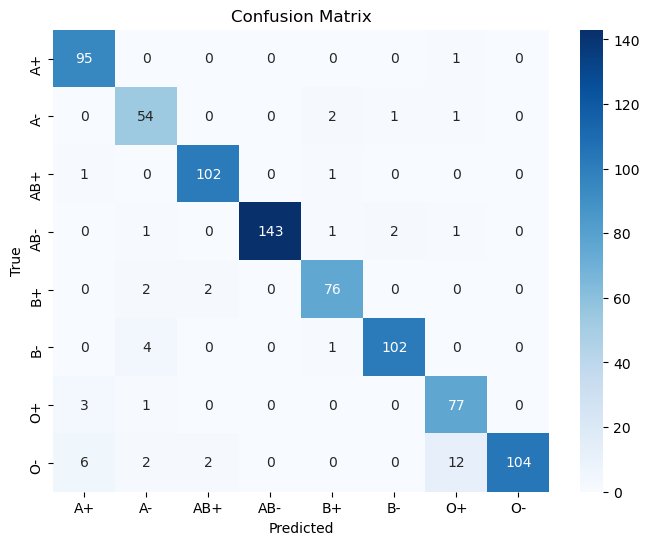

In [24]:
# Get predictions on the test dataset
y_true = []  # True labels
y_pred = []  # Predicted labels

# Iterate over the test dataset and collect the true and predicted labels
for images, labels in test_dataset:
  predictions = high_acc_model.predict(images)
  predicted_labels = np.argmax(predictions, axis=1)  #Convert one-hot encoded predictions to class labels
  y_true.extend(labels.numpy())    # Convert tensor to numpy array and append
  y_pred.extend(predicted_labels)  # Append the predicted labels

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [25]:
high_acc_model.save('my_model.h5')  # The model will be saved as 'my_model.h5'
print("Model saved as HDF5 format.")

Model saved as HDF5 format.


In [1]:
import tensorflow as tf
print(tf.__version__)


2.9.1
